## Our Environment

### Description

The LunarLander-v3 environment is a well-known problem in rocket trajectory optimization, where the goal is to control the descent and landing of a spacecraft onto a designated landing pad positioned at coordinates (0, 0) within the environment. This problem is modeled according to Pontryagin’s Maximum Principle, which suggests that the optimal control strategy is to either activate the rocket engines at full power or turn them off completely.

### Actions

There are 4 discrete deterministic actions:

    0: do nothing

    1: fire left orientation engine

    2: fire main engine

    3: fire right orientation engine

    These actions correspond to controlling the orientation and main engine to guide the lander for a successful landing.


### Observations

The observation space is an 8-dimensional vector that represents the current state of the lunar lander. These include:

    x: The x-coordinate of the lander.

    y: The y-coordinate of the lander.

    vx: The linear velocity in the x-direction.

    vy: The linear velocity in the y-direction.

    angle: The angle of the lander in radians.

    angular velocity: The rate of change of the lander's angle in radians per second.

    leg1 contact: Boolean indicating if the left leg is in contact with the ground.

    leg2 contact: Boolean indicating if the right leg is in contact with the ground.

The state space consists of real-valued continuous variables. The agent's goal is to land the lunar lander on the designated landing pad while minimizing its speed, tilt, and distance from the pad.

### Info

step() and reset() functions contains additional information to speed up training. Specifically:

p: Represents the probability of transition from the current state to the next state.

action_mask: A binary mask indicating which actions will result in a valid state transition. Some actions may have no effect on the state in certain conditions.

The step() and reset() functions return the state, reward, done (whether the episode is finished), and truncated information, as well as this extra data (if return_info=True is passed).

### Rewards

The reward function in LunarLander-v3 is as follows:

    -1 per step unless other rewards are triggered (penalty for each frame to encourage faster learning).

    +10 for each leg in contact with the ground (landing on the pad).

    -0.03 for each frame the side engines are firing.

    -0.3 for each frame the main engine is firing.

    +100 for a successful landing on the pad.

    -100 for crashing.

The episode will end when:

    The lander crashes into the surface (receives -100).

    The lander lands safely (receives +100).

    The lander moves outside of the viewport or falls asleep (no longer moving).

    An episode is considered a solution if it scores 200 points or more.



In [1]:
# !pip install stable-baselines3

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import pygame

import matplotlib.pyplot as plt
import seaborn as sns

import time
from pprint import pprint
import numpy as np
from stable_baselines3 import PPO
import torch

import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
import random

C:\Users\mainj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [3]:
# Create the LunarLander-v2 environment
env = gym.make('LunarLander-v3')

# Reset the environment to start a new episode
state, info = env.reset()
print("State Space:", env.observation_space)
print("Action Space:", env.action_space)

State Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action Space: Discrete(4)


In [4]:
env.observation_space

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

In [5]:
print(env.action_space)

Discrete(4)


In [6]:
# Discretize the state space by dividing each dimension into bins
n_bins = 10  # Number of bins for each observation dimension
state_bins = [np.linspace(-1, 1, n_bins) for _ in range(8)]

def discretize_state(state):
    discrete_state = []
    for i in range(len(state)):
        discrete_state.append(np.digitize(state[i], state_bins[i]) - 1)
    return tuple(discrete_state)

## Q-Learning

In [7]:
# Q-Learning parameters
learning_rate = 0.1
gamma = 0.99  # Discount factor
epsilon = 0.2  # Exploration rate
epsilon_decay = 0.995
min_epsilon = 0.01
n_episodes = 2000  # Number of episodes for training

# Initialize Q-table
n_actions = env.action_space.n
q_table = np.zeros([n_bins] * 8 + [n_actions])  # 8 observation dimensions and 4 actions


In [8]:
# Q-Learning parameters
learning_rate = 0.05  # Reduced learning rate
gamma = 0.95  # Discount factor, more focus on immediate rewards
epsilon = 0.5  # Initial exploration rate, higher for more exploration
epsilon_decay = 0.99  # Slower epsilon decay for longer exploration
min_epsilon = 0.05
n_episodes = 5000  # Increased episodes
n_steps = 1000  # Total timesteps for each episode

# Initialize Q-table (8 observations and 4 actions)
n_actions = env.action_space.n
q_table = np.zeros([n_bins] * 8 + [n_actions])

# Track rewards and entropy for Q-Learning
q_rewards = []
q_entropy_values = []
episode_lengths = []

# Train Q-Learning model
def train_q_learning(env):
    global epsilon
    rewards = []
    entropy_values = []
    start_time = time.time()  # Track total training time

    for episode in range(n_episodes):
        state, info = env.reset()
        discrete_state = discretize_state(state)
        total_reward = 0
        episode_entropy = 0
        states_in_episode = 0  # Track number of states per episode
        done = False
        
        while not done:
            # Exploration vs Exploitation
            if random.random() < epsilon:  # Exploration
                action = env.action_space.sample()
            else:  # Exploitation
                action = np.argmax(q_table[discrete_state])

            next_state, reward, done, truncated, info = env.step(action)
            next_discrete_state = discretize_state(next_state)

            # Q-learning update rule
            q_table[discrete_state + (action,)] += learning_rate * (
                reward + gamma * np.max(q_table[next_discrete_state]) - q_table[discrete_state + (action,)]
            )

            discrete_state = next_discrete_state
            total_reward += reward
            states_in_episode += 1  # Increment state count

        rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        entropy_values.append(episode_entropy / (episode + 1))
        episode_lengths.append(states_in_episode)  # Append episode length

        # Print episode reward and entropy every 10 episodes
        if episode % 10 == 0:
            print(f"Episode {episode} - Total Reward: {total_reward}, Average Entropy: {episode_entropy / (episode + 1)}")

    # Calculate mean reward, mean states per episode, and total time
    mean_reward = np.mean(rewards)
    mean_states_per_episode = np.mean(episode_lengths)
    end_time = time.time()
    total_time = end_time - start_time

    # Print the mean values and total time
    print(f"\nMean Reward: {mean_reward:.2f}")
    print(f"Mean States per Episode: {mean_states_per_episode:.2f}")
    print(f"Total Time Running: {total_time:.2f} seconds")

    return rewards, entropy_values

# Train Q-Learning agent
q_rewards, q_entropy_values = train_q_learning(env)

# --- Plotting Results for Q-Learning ---
plt.figure(figsize=(12, 6))

# Plotting Q-Learning rewards
plt.subplot(2, 1, 1)
plt.plot(q_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training Progress - Rewards')

# Plotting Q-Learning entropy (exploration vs exploitation)
plt.subplot(2, 1, 2)
plt.plot(q_entropy_values)
plt.xlabel('Episodes')
plt.ylabel('Entropy')
plt.title('Q-Learning Training Progress - Entropy (Exploration vs Exploitation)')

plt.tight_layout()
plt.show()

Episode 0 - Total Reward: -240.28070751519007, Average Entropy: 0.0
Episode 10 - Total Reward: -371.1092773032285, Average Entropy: 0.0
Episode 20 - Total Reward: -56.33246616200306, Average Entropy: 0.0
Episode 30 - Total Reward: -257.0214109260559, Average Entropy: 0.0
Episode 40 - Total Reward: -110.84882976430828, Average Entropy: 0.0
Episode 50 - Total Reward: -246.78527407789784, Average Entropy: 0.0
Episode 60 - Total Reward: -172.81050164302258, Average Entropy: 0.0
Episode 70 - Total Reward: -20.415198307348305, Average Entropy: 0.0
Episode 80 - Total Reward: -236.35270183641728, Average Entropy: 0.0
Episode 90 - Total Reward: -139.64195908902627, Average Entropy: 0.0
Episode 100 - Total Reward: -82.79591406276799, Average Entropy: 0.0
Episode 110 - Total Reward: -239.81076395179727, Average Entropy: 0.0
Episode 120 - Total Reward: -173.60457372422934, Average Entropy: 0.0
Episode 130 - Total Reward: -209.82394554438, Average Entropy: 0.0
Episode 140 - Total Reward: -73.690880

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 0 - Total Reward: -372.8608904992605, Average Entropy: 73.47331643104553
Episode 10 - Total Reward: -561.081453696758, Average Entropy: 8.821833502162587
Episode 20 - Total Reward: -481.7065032395486, Average Entropy: 4.620957522165208
Episode 30 - Total Reward: -530.2371154709675, Average Entropy: 2.638421577792014
Episode 40 - Total Reward: -558.2208962285965, Average Entropy: 2.2315850345099846
Episode 50 - Total Reward: -977.3270092610443, Average Entropy: 2.310478315633886
Episode 60 - Total Reward: -1059.6848934642608, Average Entropy: 2.4316828035917437
Episode 70 - Total Reward: -573.5517953965066, Average Entropy: 1.308187164051432
Episode 80 - Total Reward: -386.65213436850735, Average Entropy: 0.8215057172893007
Episode 90 - Total Reward: -906.4886780220271, Average Entropy: 1.2948831149509974
Episode 100 - Total Reward: -759.6969546835377, Average Entropy: 1.056872390284396

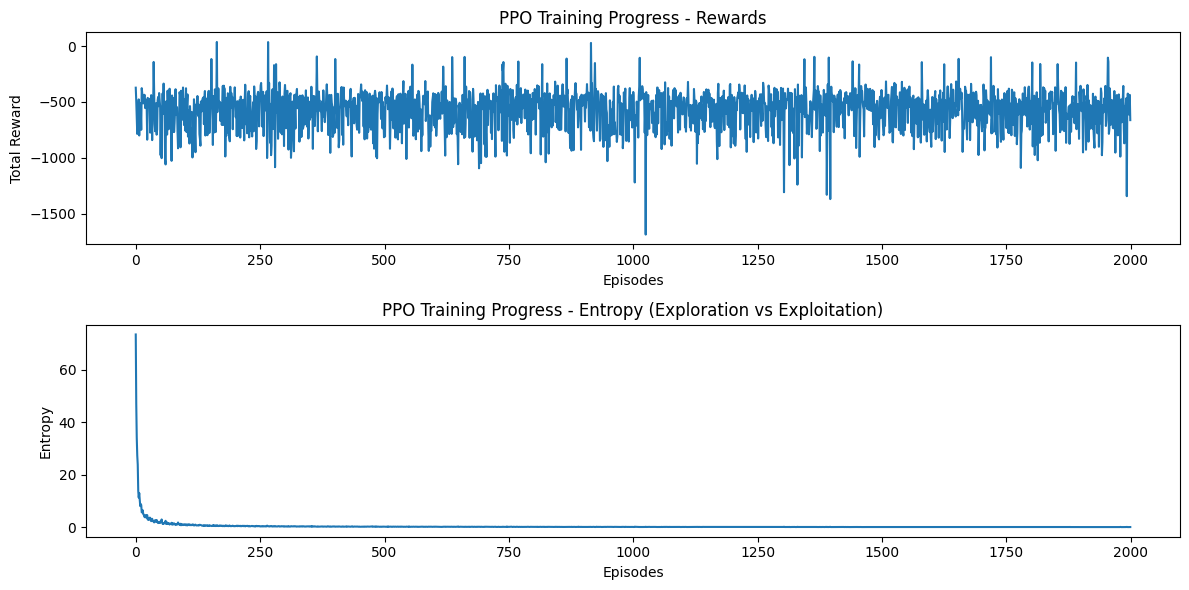

In [9]:
# Define PPO model
ppo_model = PPO("MlpPolicy", env, verbose=1)

# List to store rewards and entropy during training for PPO
ppo_rewards = []
ppo_entropy_values = []
episode_lengths = []  # List to track number of states (steps) per episode

# Train PPO model and store rewards and entropy
def train_ppo():
    start_time = time.time()  # Track total training time
    for episode in range(2000):  # Or choose a suitable number of episodes
        state, info = env.reset()  # Reset the environment
        done = False
        total_reward = 0
        episode_entropy = 0  # To store the total entropy for the episode
        states_in_episode = 0  # Track the number of states per episode

        while not done:
            # Get the action from the policy
            action, _states = ppo_model.predict(state, deterministic=True)

            # Ensure the action is an integer (required by LunarLander)
            action = int(action)  # Convert the action to an integer (LunarLander expects an int)

            # Get action distribution from the policy
            action_dist = ppo_model.policy.get_distribution(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
            
            # Log probability of the action taken (for entropy calculation)
            log_prob = action_dist.log_prob(torch.tensor(action).unsqueeze(0))  # Log probability of the action taken

            # Entropy of the current action distribution
            entropy = action_dist.entropy().mean().item()  # Entropy calculation

            # Step the environment
            state, reward, done, _, info = env.step(action)
            total_reward += reward
            episode_entropy += entropy  # Sum up entropy over the episode
            states_in_episode += 1  # Increment state count

        # Store the reward, entropy, and episode length
        ppo_rewards.append(total_reward)
        ppo_entropy_values.append(episode_entropy / (episode + 1))  # Normalize entropy per episode
        episode_lengths.append(states_in_episode)  # Append episode length

        # Print episode reward and entropy every 10 episodes
        if episode % 10 == 0:
            print(f"Episode {episode} - Total Reward: {total_reward}, Average Entropy: {episode_entropy / (episode + 1)}")

    # Calculate mean reward, mean states per episode, and total time
    mean_reward = np.mean(ppo_rewards)
    mean_states_per_episode = np.mean(episode_lengths)
    end_time = time.time()
    total_time = end_time - start_time

    # Print the mean values and total time
    print(f"\nMean Reward: {mean_reward:.2f}")
    print(f"Mean States per Episode: {mean_states_per_episode:.2f}")
    print(f"Total Time Running: {total_time:.2f} seconds")

# Train PPO agent
train_ppo()

# --- Plotting Results for PPO ---
plt.figure(figsize=(12, 6))

# Plotting PPO rewards
plt.subplot(2, 1, 1)
plt.plot(ppo_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('PPO Training Progress - Rewards')

# Plotting PPO entropy (exploration vs exploitation)
plt.subplot(2, 1, 2)
plt.plot(ppo_entropy_values)
plt.xlabel('Episodes')
plt.ylabel('Entropy')
plt.title('PPO Training Progress - Entropy (Exploration vs Exploitation)')

plt.tight_layout()
plt.show()

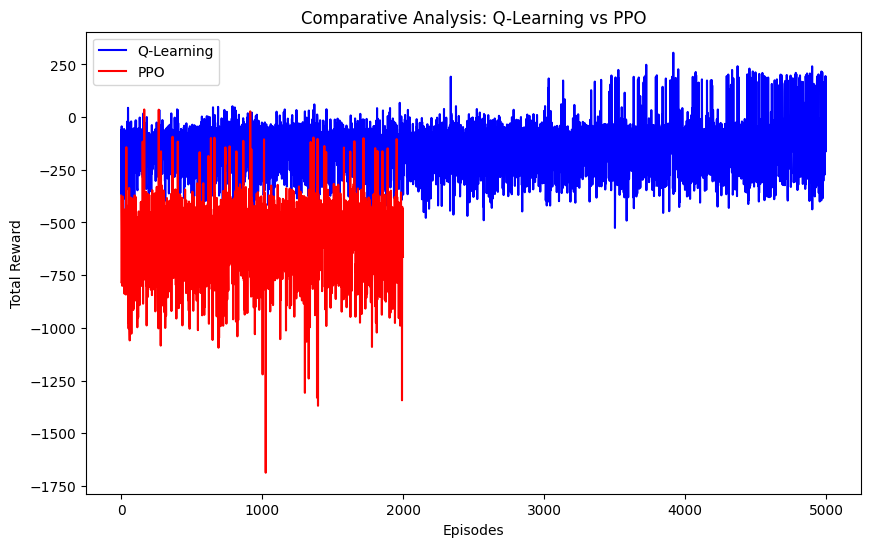

In [10]:
plt.figure(figsize=(10, 6))

# Plot Q-Learning and PPO reward curves
plt.plot(q_rewards, label='Q-Learning', color='blue')
plt.plot(ppo_rewards, label='PPO', color='red')

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Comparative Analysis: Q-Learning vs PPO')
plt.legend()

# Show the plot
plt.show()

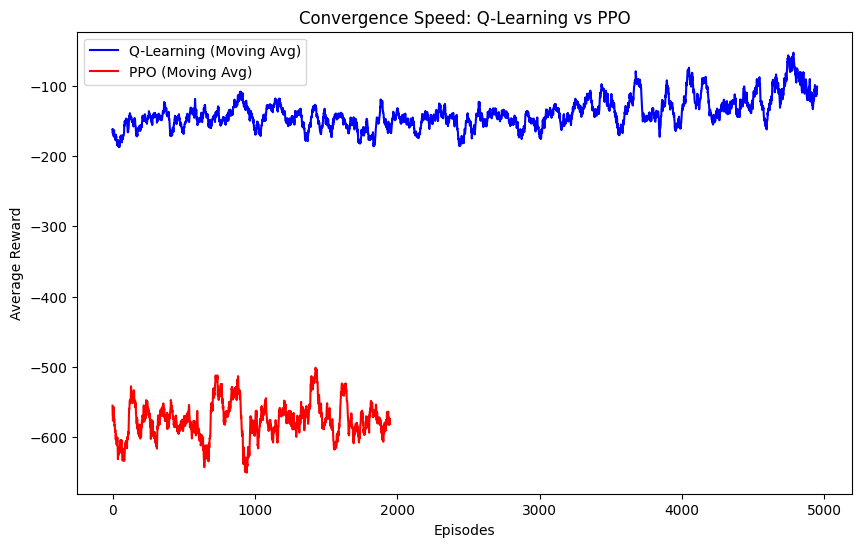

In [11]:
# Compute moving average of rewards for smoother comparison
window = 50  # Size of the moving window (50 episodes for example)
qlearning_avg_rewards = np.convolve(q_rewards, np.ones(window)/window, mode='valid')
ppo_avg_rewards = np.convolve(ppo_rewards, np.ones(window)/window, mode='valid')

# Plotting the moving average comparison
plt.figure(figsize=(10, 6))
plt.plot(qlearning_avg_rewards, label='Q-Learning (Moving Avg)', color='blue')
plt.plot(ppo_avg_rewards, label='PPO (Moving Avg)', color='red')

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Convergence Speed: Q-Learning vs PPO')
plt.legend()

# Show the plot
plt.show()